# Homework 4: Modeling Text Data

### Team Member 1:
* UNI:  WL2522
* Name: Wilson Lui

### Team Member 2 [optional]:
* UNI:  
* Name:


You can find the data here: https://data.boston.gov/dataset/vision-zero-entry

# Task1 - Data Cleaning  [10 points]

Load the data, visualize the class distribution. Clean up the target labels. Some categories have been arbitrarily split and need to be consolidated. 

First, rows with no comments or duplicate rows that have the same combination of request type and comment are removed. Rows with  comments that are less than 12 characters long were also removed due to comments of that length not being too informative.


Then, embedded image tags are removed from the categories.

Having removed the embedded image tags from the categories, the following categories are consolidated due to them having the same meaning with different wordings:


1. "bike facilities don't exist or need improvement" / "there are no bike facilities or they need maintenance"

2. "sidewalks/ramps don't exist or need improvement" / "there are no sidewalks or they need maintenance"

3. "the wait for the "Walk" signal is too long" / "people have to wait too long for the "Walk" signal"

4. "the roadway surface needs improvement" / "the roadway surface needs maintenance"

5. "it’s hard to see / low visibility" / "it’s hard for people to see each other"

6. "it's too far / too many lanes to cross" / "people have to cross too many lanes / too far"

7. "people are not given enough time to cross the street" / "there's not enough time to cross the street"

The following categories are very similar to each other, but not quite the same, and thus were not combined during this preprocessing step:


>"people don't yield while going straight" / "people don't yield while turning" /  "people run red lights / stop signs"


Whenever categories are consolidated, I merge the category with fewer data points into the one with more data points.


In [11]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import re

from scipy.sparse import hstack
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, f1_score, adjusted_rand_score
from sklearn.preprocessing import Normalizer, MaxAbsScaler

from sklearn.pipeline import make_pipeline, make_union

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, LatentDirichletAllocation

data = pd.read_csv('Vision_Zero_Entry.csv')


["bike facilities don't exist or need improvement"
 'of something that is not listed here'
 "people don't yield while going straight"
 'it’s hard to see / low visibility' "people don't yield while turning"
 'people double park their vehicles'
 'the wait for the "Walk" signal is too long'
 "sidewalks/ramps don't exist or need improvement" 'people speed'
 'people cross away from the crosswalks'
 "there's not enough time to cross the street"
 "it's too far / too many lanes to cross"
 'people run red lights / stop signs'
 'the roadway surface needs improvement'
 'there are no bike facilities or they need maintenance'
 'the roadway surface needs maintenance'
 'people have to cross too many lanes / too far'
 'there are no sidewalks or they need maintenance'
 'people have to wait too long for the "Walk" signal'
 'it’s hard for people to see each other'
 'people are not given enough time to cross the street'
 '" src="images/10 - Hard to see.png"></span>&nbsp;it’s hard to see / low visibility'


([<matplotlib.axis.YTick at 0x26f74ba6b70>,
 <a list of 28 Text yticklabel objects>)

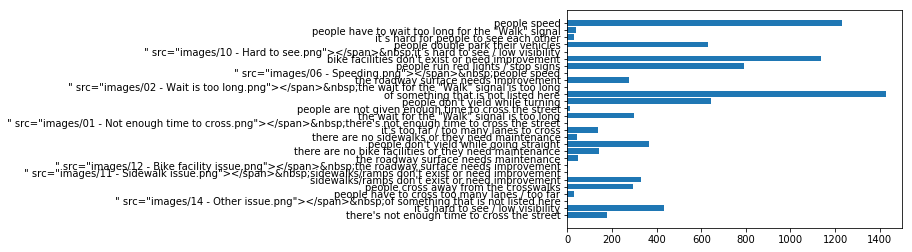

In [12]:
#Visualize the distribution of the categories


print(data['REQUESTTYPE'].unique())
plt.barh(range(len(data['REQUESTTYPE'].unique())), list(Counter(data['REQUESTTYPE']).values()), align='center')
plt.yticks(range(len(data['REQUESTTYPE'].unique())), list(Counter(data['REQUESTTYPE']).keys()))


In [13]:
#Remove rows with no comments
#Remove duplicate rows that have the same category and comment
#Remove rows with comments that are less than 12 characters long
#Create a list of categories
#Consolidate the categories that have embedded images tags into corresponding categories


data = data[data['COMMENTS'].notnull()]
data = data.drop_duplicates(subset=['REQUESTTYPE', 'COMMENTS'])
data = data[data['COMMENTS'].str.len() > 12]


print(len(data['REQUESTTYPE'].unique()))
categories = data['REQUESTTYPE'].unique()
categories = categories.tolist()
categories.sort()

for a in range(len(categories)): print(categories[a])
    
data['REQUESTTYPE'].replace(to_replace=categories[0:7], value=[
        "there's not enough time to cross the street",
    'the wait for the "Walk" signal is too long',
    'people speed', 'it’s hard to see / low visibility',
        "sidewalks/ramps don't exist or need improvement", "the roadway surface needs improvement",
    "of something that is not listed here"], inplace=True)

print(data['REQUESTTYPE'].unique())
print(len(data['REQUESTTYPE'].unique()))


28
" src="images/01 - Not enough time to cross.png"></span>&nbsp;there's not enough time to cross the street
" src="images/02 - Wait is too long.png"></span>&nbsp;the wait for the "Walk" signal is too long
" src="images/06 - Speeding.png"></span>&nbsp;people speed
" src="images/10 - Hard to see.png"></span>&nbsp;it’s hard to see / low visibility
" src="images/11 - Sidewalk issue.png"></span>&nbsp;sidewalks/ramps don't exist or need improvement
" src="images/12 - Bike facility issue.png"></span>&nbsp;the roadway surface needs improvement
" src="images/14 - Other issue.png"></span>&nbsp;of something that is not listed here
bike facilities don't exist or need improvement
it's too far / too many lanes to cross
it’s hard for people to see each other
it’s hard to see / low visibility
of something that is not listed here
people are not given enough time to cross the street
people cross away from the crosswalks
people don't yield while going straight
people don't yield while turning
people dou

["bike facilities don't exist or need improvement"
 'of something that is not listed here'
 "people don't yield while going straight"
 'it’s hard to see / low visibility' "people don't yield while turning"
 'the wait for the "Walk" signal is too long'
 "sidewalks/ramps don't exist or need improvement"
 'people cross away from the crosswalks'
 'people double park their vehicles' 'people speed'
 'people run red lights / stop signs'
 "it's too far / too many lanes to cross"
 "there's not enough time to cross the street"
 'the roadway surface needs improvement'
 'there are no bike facilities or they need maintenance'
 'the roadway surface needs maintenance'
 'people have to cross too many lanes / too far'
 'there are no sidewalks or they need maintenance'
 'it’s hard for people to see each other'
 'people have to wait too long for the "Walk" signal'
 'people are not given enough time to cross the street']


([<matplotlib.axis.YTick at 0x26f73040828>,
 <a list of 21 Text yticklabel objects>)

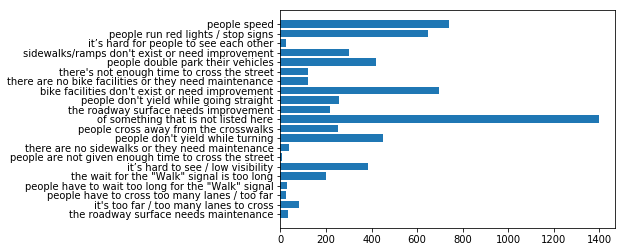

In [14]:
#Visualize the distribution of the categories after the first round of category consolidation


print(data['REQUESTTYPE'].unique())
plt.barh(range(len(data['REQUESTTYPE'].unique())), list(Counter(data['REQUESTTYPE']).values()), align='center')
plt.yticks(range(len(data['REQUESTTYPE'].unique())), list(Counter(data['REQUESTTYPE']).keys()))


In [15]:
#Count how many occurrences of each category occur in the dataset
#Create a list with tuples containing each category and its number of occurrences


count = Counter(data['REQUESTTYPE'])
count = count.items()
count = list(count)
count.sort()
print(count)

print(count[14][0], count[19][0])
print(count[0][0], count[18][0])
print(count[11][0], count[17][0])
print(count[15][0], count[16][0])
print(count[2][0], count[3][0])
print(count[1][0], count[10][0])
print(count[5][0], count[20][0])


[("bike facilities don't exist or need improvement", 695), ("it's too far / too many lanes to cross", 82), ('it’s hard for people to see each other', 26), ('it’s hard to see / low visibility', 385), ('of something that is not listed here', 1400), ('people are not given enough time to cross the street', 9), ('people cross away from the crosswalks', 254), ("people don't yield while going straight", 256), ("people don't yield while turning", 451), ('people double park their vehicles', 418), ('people have to cross too many lanes / too far', 24), ('people have to wait too long for the "Walk" signal', 27), ('people run red lights / stop signs', 647), ('people speed', 741), ("sidewalks/ramps don't exist or need improvement", 299), ('the roadway surface needs improvement', 216), ('the roadway surface needs maintenance', 34), ('the wait for the "Walk" signal is too long', 198), ('there are no bike facilities or they need maintenance', 122), ('there are no sidewalks or they need maintenance', 38

In [16]:
#For each category pair, check which category appears less often
#Replace that category with the other category


#bike facilities don't exist or need improvement / there are no bike facilities or they need maintenance


if count[0][1] > count[18][1]: 
    data['REQUESTTYPE'].replace(to_replace=count[18][0], value=count[0][0], inplace=True)

elif count[18][1] > count[0][1]:
    data['REQUESTTYPE'].replace(to_replace=count[0][0], value=count[18][0], inplace=True)

    
#sidewalks/ramps don't exist or need improvement / there are no sidewalks or they need maintenance


if count[14][1] > count[19][1]:
    data['REQUESTTYPE'].replace(to_replace=count[19][0], value=count[14][0], inplace=True)
    
elif count[19][1] > count[14][1]:
    data['REQUESTTYPE'].replace(to_replace=count[14][0], value=count[19][0], inplace=True)
    
    
#people have to wait too long for the "Walk" signal / the wait for the "Walk" signal is too long


if count[11][1] > count[17][1]:
    data['REQUESTTYPE'].replace(to_replace=count[17][0], value=count[11][0], inplace=True)
    
elif count[17][1] > count[11][1]:
    data['REQUESTTYPE'].replace(to_replace=count[11][0], value=count[17][0], inplace=True)
    

#the roadway surface needs improvement / the roadway surface needs maintenance


if count[15][1] > count[16][1]:
    data['REQUESTTYPE'].replace(to_replace=count[16][0], value=count[15][0], inplace=True)
    
elif count[16][1] > count[15][1]:
    data['REQUESTTYPE'].replace(to_replace=count[15][0], value=count[16][0], inplace=True)
    
    
#it’s hard to see / low visibility / it’s hard for people to see each other


if count[2][1] > count[3][1]:
    data['REQUESTTYPE'].replace(to_replace=count[3][0], value=count[2][0], inplace=True)
    
elif count[3][1] > count[2][1]:
    data['REQUESTTYPE'].replace(to_replace=count[2][0], value=count[3][0], inplace=True)
    
    
#it's too far / too many lanes to cross / people have to cross too many lanes / too far


if count[1][1] > count[10][1]:
    data['REQUESTTYPE'].replace(to_replace=count[10][0], value=count[1][0], inplace=True)
    
elif count[10][1] > count[1][1]:
    data['REQUESTTYPE'].replace(to_replace[1][0], value=count[10][0], inplace=True)

    
#people are not given enough time to cross the street / there's not enough time to cross the street


if count[5][1] > count[20][1]:
    data['REQUESTTYPE'].replace(to_replace=count[20][0], value=count[5][0], inplace=True)
    
elif count[20][1] > count[5][1]:
    data['REQUESTTYPE'].replace(to_replace=count[5][0], value=count[20][0], inplace=True)

print(Counter(data['REQUESTTYPE']))
print(len(data['REQUESTTYPE'].unique()))


Counter({'of something that is not listed here': 1400, "bike facilities don't exist or need improvement": 817, 'people speed': 741, 'people run red lights / stop signs': 647, "people don't yield while turning": 451, 'people double park their vehicles': 418, 'it’s hard to see / low visibility': 411, "sidewalks/ramps don't exist or need improvement": 337, "people don't yield while going straight": 256, 'people cross away from the crosswalks': 254, 'the roadway surface needs improvement': 250, 'the wait for the "Walk" signal is too long': 225, "there's not enough time to cross the street": 131, "it's too far / too many lanes to cross": 106})
14


In [17]:
#Make a copy of the dataset
#Separate the features from the response variable

consolidated_data = data.copy()

target = data['REQUESTTYPE']
comments = data['COMMENTS']


["bike facilities don't exist or need improvement"
 'of something that is not listed here'
 "people don't yield while going straight"
 'it’s hard to see / low visibility' "people don't yield while turning"
 'the wait for the "Walk" signal is too long'
 "sidewalks/ramps don't exist or need improvement"
 'people cross away from the crosswalks'
 'people double park their vehicles' 'people speed'
 'people run red lights / stop signs'
 "it's too far / too many lanes to cross"
 "there's not enough time to cross the street"
 'the roadway surface needs improvement']


([<matplotlib.axis.YTick at 0x26f72f4acc0>,
 <a list of 14 Text yticklabel objects>)

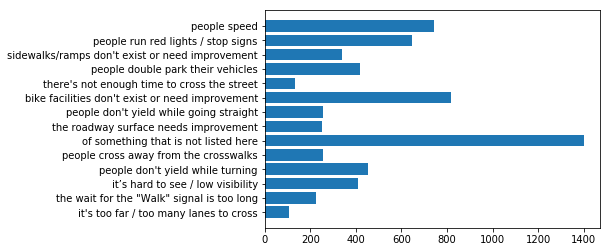

In [18]:
#Visualize the distribution of the consolidated categories


print(target.unique())
plt.barh(range(len(target.unique())), list(Counter(target).values()), align='center')
plt.yticks(range(len(target.unique())), list(Counter(target).keys()))


# Task2 - Model 1 [10 points]

Run a baseline multi-class classification model using a bag-of-word approach, report macro f1-score (should be above .5) and visualize the confusion matrix. Can you interpret the mistakes made by the model? 

The original selection of 28 categories have now been consolidated into the following 14:


1. "bike facilities don't exist or need improvement"

2. "of something that is not listed here"

3. "people don't yield while going straight"

4. "it’s hard to see / low visibility"

5. "people don't yield while turning"

6. "the wait for the "Walk" signal is too long"

7. "sidewalks/ramps don't exist or need improvement"

8. "people cross away from the crosswalks"

9. "people double park their vehicles"

10. "people speed"

11. "people run red lights / stop signs"

12. "it's too far / too many lanes to cross"

13. "there's not enough time to cross the street"

14. "the roadway surface needs improvement"
 
 

In [66]:
#Split the dataset into training and test sets
#Vectorize the comments


comments_train, comments_test, target_train, target_test = train_test_split(comments,
                                                                            target, stratify=target,
                                                                           random_state=3)

vect = CountVectorizer()

X_train = vect.fit_transform(comments_train)
X_test = vect.transform(comments_test)

#X_train_scaled = reg.fit_transform(X_train)
#X_test_scaled = reg.transform(X_test)


In [67]:
#Score a baseline multinomial naive Bayes model using F1-macro score


baseline = np.mean(cross_val_score(LogisticRegression(random_state=3), X_train, target_train,
                                   cv=5, scoring='f1_macro', n_jobs=8))
print('Baseline F1 Macro score:', baseline)

assert baseline > 0.5


Baseline F1 Macro score: 0.514581885128


In [68]:
#Display the confusion matrix and classification report


lr = LogisticRegression(random_state=3)
lr.fit(X_train, target_train)

np.set_printoptions(linewidth=100)

baseline_preds = cross_val_predict(lr, X_train, target_train, cv=5, n_jobs=8)

print(confusion_matrix(target_train, baseline_preds))
print(classification_report(target_train, baseline_preds))
      

[[454   3   1  78   0   1  14  16   4  16  14   9   3   0]
 [  7   6   5  26  10   3   2   0   2   7   1   3   5   2]
 [ 11   0 178  65   1   5   8   2  10  24   2   1   1   0]
 [ 85   3  40 545  42  25  56  34  74  59  50  16  12   9]
 [  2   1   1  57  85   9  11   1   4   8   7   1   1   3]
 [ 14   0  11  42   4  53  20   2  10  28   4   0   3   1]
 [ 20   0  14  79   4  20 152   2  20  17   1   2   5   2]
 [ 24   0   2  69   1   0   2 205   3   3   2   2   1   0]
 [  7   0   5  78   5  12  14   0 317  37   1   0   7   2]
 [ 23   3  19  72   2  12  13   5  34 367   3   0   2   1]
 [ 15   0   1  58  10   1   2   4   1   6 148   4   3   0]
 [ 35   0   3  36   1   1   2   5   2   2   7  92   1   0]
 [  2   0   2  37   3   1   6   0   8   2   2   0  95  11]
 [  1   1   2  26   6   2   7   0   4   6   1   0  16  26]]
                                                 precision    recall  f1-score   support

bike facilities don't exist or need improvement       0.65      0.74      0.69     

From the confusion matrix and classification report, it appears that model is having trouble with these particular aspects of the model:

1. There are a great number of data points that are incorrectly classified as "of something that is not listed here". There are also many data points belonging to that category but incorrectly classified as other categories. Browsing through the comments belonging to "of something that is not listed here", it seems that many should belong to categories that already exist. Without having looked at the interface through which these complaints were collected, I would guess that maybe "of something that is not listed here" is the default option and many people don't bother changing it before submitting their complaints

2. The similarities between comments in the group "people don't yield while going straight", "people don't yield while turning", and "people run red lights / stop signs" are confusing the model. In the confusion matrix, it appears that a portion of the data points in each category are being mistakenly classified as other categories in this group.

3. Some data points in the "people speed" and "people run red lights / stop signs" categories are being mistakenly categorized as the other category. Similar to #1, many other data points belonging to other categories are being mistakenly categorized as one of these two categories.

4. Some data points in the group "bike facilities don't exist or need improvement", "sidewalks/ramps don't exist or need improvement", and "the roadway surface needs improvement" categories are being mistakenly categorized as other categories in this group. This seems to be due to the fact that complaints about bike facilities include those about poor road conditions or faded lane marking paint in bike lanes, which would overlap with comments about sidewalks and roadway conditions.

5. To a lesser extent than in #1, many data points are being mistakenly classified as "bike facilities don't exist or need improvement", most likely due to complaints about the bike facilities mentioning poor road conditions or danger due to traffic.


# Task3 - Model 2 [30 points]

Improve the model using more complex text features, including n-grams, character n-grams and possibly domain-specific features.

I began removing stop words using CountVectorizer since I saw that it reduced the number of features while achieving the same accuracy. I then performed grid searches using the following models to see if I can get better performance:


1. Multinomial Naive Bayes
2. Logistic Regression
3. Random Forest
4. SVM


I searched over the following parameter grid for CountVectorizer():


1. 'ngram_range': [(1, 1), (1, 2), (1, 5), (1, 7), (2, 3), (2, 5), (3, 8), (5, 5)]
2. 'analyzer': ['word', 'char', 'char_wb'],
3. 'min_df': [1, 2, 3],
4. 'normalizer': [None, Normalizer()]

Based on the results, I decided to continue with Naive Bayes and Logistic Regression since they performed the best, with similar cross-validation scores using the optimal parameters.


The optimal CountVectorizer() parameters to use with a Naive Bayes model were:


>{'normalizer': None, 'min_df': 3, 'analyzer': 'char_wb', 'ngram_range': (2, 5)}


The optimal CountVectorizer() parameters to use with a Logistic Regression model were:


>{'normalizer': None, 'ngram_range': (3, 8), 'min_df': 2, 'analyzer': 'char'}


Next, I used tf-idf rescaling on these two models and found that they greatly reduced the accuracy of the model compared with CountVectorizer(). 


I also tried adding a feature indicating the length of the original comment string and found that it either improved or worsened the model by a negligible amount. Therefore I decided not to include that feature in my model.


Finally, I incorporated a lemmatization function from the spaCy package to use as a custom tokenizer for CountVectorizer(). This change slightly increased my F1 macro score.



In [69]:
#Remove stop words when vectorizing the dataset


stop = CountVectorizer(stop_words='english')

X_train = stop.fit_transform(comments_train)
X_test = stop.transform(comments_test)

lr.fit(X_train, target_train)
stop_score = cross_val_score(lr, X_train, target_train, cv=5, scoring='f1_macro', n_jobs=8)

print('Stop Word Removal Scores:', stop_score)
print('Stop Word Removal Mean Score:', np.mean(stop_score))


Stop Word Removal Scores: [ 0.52890967  0.48834931  0.49922607  0.53828119  0.51008299]
Stop Word Removal Mean Score: 0.512969846191


This section has been commented out to prevent Travis-CI from timing out
------------------------------------------------------------------------


Best score achieved through GridSearchCV with a Multinomial Naive Bayes model:
    

>0.525103133804


Best parameters:


>{'normalizer': None, 'min_df': 3, 'analyzer': 'char_wb', 'ngram_range': (2, 5)}



In [70]:
#Grid search using a naive Bayes model to find the best model paramaters


#params = {'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 5), (1, 7),
#                                (2, 3), (2, 5), (3, 8), (5, 5)],
#             'countvectorizer__analyzer': ['word', 'char', 'char_wb'],
#           'countvectorizer__min_df': [1, 2, 3],
#           'normalizer': [None, Normalizer()]
#}

#nb_grid = GridSearchCV(make_pipeline(CountVectorizer(stop_words='english'),
#                                  Normalizer(), MultinomialNB()) ,
#                    param_grid=params, cv=5, scoring='f1_macro', n_jobs=8)

#nb_grid.fit(comments_train, target_train)
#print(nb_grid.best_score_)
#print(nb_grid.best_params_)


This section has been commented out to prevent Travis-CI from timing out
------------------------------------------------------------------------

Best score achieved through GridSearchCV with a logistic regression model:


>0.544554548341


Best parameters:


>{'normalizer': None, 'ngram_range': (3, 8), 'min_df': 2, 'analyzer': 'char', 'C': 0.1}




In [71]:
#Grid search using a logistic regression model to find the best model paramaters


#lr_params = {'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 5), (1, 7),
#                                (2, 3), (2, 5), (3, 8), (5, 5)],
#             'countvectorizer__analyzer': ['word', 'char', 'char_wb'],
#           'countvectorizer__min_df': [1, 2, 3],
#           'normalizer': [None, Normalizer()],
#          'logisticregression__C': [100, 10, 1, 0.1, 0.01]
#        }

#lr_grid = GridSearchCV(make_pipeline(CountVectorizer(stop_words='english'),
#                                    Normalizer(), LogisticRegression()), 
#                       param_grid=lr_params, cv=5, scoring='f1_macro', n_jobs=8, verbose=2)

#lr_grid.fit(comments_train, target_train)
#print(lr_grid.best_score_)
#print(lr_grid.best_params_)


This section has been commented out to prevent Travis-CI from timing out
------------------------------------------------------------------------

Best score achieved through GridSearchCV with a random forest model:


>0.505797024798


Best parameters:


>{'normalizer': None, 'n_estimators': 200, 'ngram_range': (5, 5), 'analyzer': 'char', 'min_df': 3}



In [72]:
#Grid search using a random forest model to find the best model parameters


#rf_params = {'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 5), (1, 7),
#                                (2, 3), (2, 5), (3, 8), (5, 5)],
#             'countvectorizer__analyzer': ['word', 'char', 'char_wb'],
#           'countvectorizer__min_df': [1, 2, 3],
#           'normalizer': [None, Normalizer()],
#             'randomforestclassifier__n_estimators': [50, 100, 150, 200],
#        }

#rf_grid = GridSearchCV(make_pipeline(CountVectorizer(stop_words='english'),
#                                    Normalizer(), RandomForestClassifier()),
#                      param_grid=rf_params, cv=5, scoring='f1_macro', n_jobs=8, verbose=3)

#rf_grid.fit(comments_train, target_train)
#print(rf_grid.best_score_)
#print(rf_grid.best_params_)


In [73]:
#Grid search using an SVM model to find the best model parameters


#sv_params = {'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 5), (1, 7),
#                                (2, 3), (2, 5), (3, 8), (5, 5)],
#             'countvectorizer__analyzer': ['word', 'char', 'char_wb'],
#           'countvectorizer__min_df': [1, 2, 3],
#           'normalizer': [None, Normalizer()],
#          'svc__C': [100, 10, 1, 0.1, 0.01]
#        }

#sv_grid = GridSearchCV(make_pipeline(CountVectorizer(stop_words='english'),
#                                     Normalizer(), SVC()),
#                                    param_grid=sv_params, cv=5, scoring='f1_macro', verbose=2)

#sv_grid.fit(comments_train, target_train)
#print(sv_grid.best_score_)
#print(sv_grid.best_params_)


In [74]:
#Compare tf-idf rescaling with CountVectorizer using the best Logistic Regression model parameters
#{'normalizer': None, 'ngram_range': (3, 8), 'min_df': 2, 'analyzer': 'char', 'C': 0.1}

tf_lr_pipe = make_pipeline(TfidfVectorizer(stop_words='english', ngram_range=(3, 8),
                                           min_df=2, analyzer='char'),LogisticRegression(C=0.1))

cv_lr_pipe = make_pipeline(CountVectorizer(stop_words='english', ngram_range=(3, 8), 
                                           min_df=2, analyzer='char'), LogisticRegression(C=0.1))

tf_lr_pipe.fit(comments_train, target_train)
cv_lr_pipe.fit(comments_train, target_train)

tf_score = cross_val_score(tf_lr_pipe, comments_train, target_train, cv=5, scoring='f1_macro', n_jobs=8)
cv_score = cross_val_score(cv_lr_pipe, comments_train, target_train, cv=5, scoring='f1_macro', n_jobs=8)

print('tfidf scores:', tf_score)
print('tfidf mean score', np.mean(tf_score))
print('CountVectorizer scores', cv_score)
print('CountVectorizer mean score', np.mean(cv_score))


tfidf scores: [ 0.09081819  0.0896437   0.08717221  0.08955632  0.10823895]
tfidf mean score 0.0930858747552
CountVectorizer scores [ 0.54406666  0.51813003  0.53888965  0.54986739  0.53157476]
CountVectorizer mean score 0.536505698152


In [75]:
#Compare tf-idf rescaling with CountVectorizer using the best Naive Bayes model parameters
#{'normalizer': None, 'min_df': 3, 'analyzer': 'char_wb', 'ngram_range': (2, 5)}


tf_nb_pipe = make_pipeline(TfidfVectorizer(stop_words='english', ngram_range=(2, 5), 
                                           min_df=3, analyzer='char_wb'), MultinomialNB())

cv_nb_pipe = make_pipeline(CountVectorizer(stop_words='engish', ngram_range=(2, 5),
                                          min_df=3, analyzer='char_wb'), MultinomialNB())

print('tfidf:',
      cross_val_score(tf_nb_pipe, comments_train, target_train,
                      cv=5, scoring='f1_macro', n_jobs=8))
print('CountVectorizer',
     cross_val_score(cv_nb_pipe, comments_train, target_train,
                     cv=5, scoring='f1_macro', n_jobs=8))


tfidf: [ 0.1217809   0.13018391  0.11988127  0.10391956  0.11592905]
CountVectorizer [ 0.5326411   0.53283782  0.52351483  0.50213999  0.53429213]


In [76]:
#Add feature that indicates the length of the original comment string
#Evaluate this model using Naive Bayes


nb_cv = CountVectorizer(stop_words='english', ngram_range=(2, 5),
                       min_df=3, analyzer='char_wb')

train_len = comments_train.str.len()
train_len = np.reshape(train_len, (4833, 1))


comments_len = nb_cv.fit_transform(comments_train)
comments_len = hstack((comments_len, train_len))

nb_score = cross_val_score(MultinomialNB(), comments_len, target_train, cv=5,
                           scoring='f1_macro', n_jobs=8)

print('nb scores:', nb_score)
print('nb mean score:', np.mean(nb_score))


C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


nb scores: [ 0.51692009  0.51441714  0.50502863  0.48843074  0.53145467]
nb mean score: 0.511250254695


In [77]:
#Evaluate this model using Logistic Regression


lr_cv = CountVectorizer(stop_words='english', ngram_range=(3, 8),
                       min_df=2, analyzer='char')

comments_len = lr_cv.fit_transform(comments_train)
comments_len = hstack((comments_len, train_len))

lr_score = cross_val_score(LogisticRegression(C=0.1), comments_len, target_train, cv=5,
                           scoring='f1_macro', n_jobs=8)

print('LR scores:', lr_score)      
print('LR mean score:', np.mean(lr_score))     


LR scores: [ 0.55055735  0.5150431   0.53707717  0.55339255  0.52731333]
LR mean score: 0.536676700182


In [78]:
#Implement a custom tokenizer that uses spaCy to perform lemmatization on the comments first


regexp = re.compile('(?u)\\b\\w\\w+\\b')
en_nlp = spacy.load('en_default')

old_tokenizer = en_nlp.tokenizer

en_nlp.tokenizer = lambda string: old_tokenizer.tokens_from_list(
regexp.findall(string))

def custom_tokenizer(document):
    doc_spacy = en_nlp(document, entity=False, parse=False)
    
    return [token.lemma_ for token in doc_spacy]


In [79]:
#Evaluate this model using Logistic Regression


lr_lemma_pipe = make_pipeline(CountVectorizer(tokenizer=custom_tokenizer, stop_words='english',
                            ngram_range=(3, 8), min_df=2, analyzer='char'), LogisticRegression(C=0.1))

lr_lemma_pipe.fit(comments_train, target_train)
lr_lemma_score = cross_val_score(lr_lemma_pipe, comments_train, target_train, cv=5,
                                scoring='f1_macro')

print('LR Lemmatization Scores:', lr_lemma_score)
print('LR Lemmatization Mean Scores:', np.mean(lr_lemma_score))


LR Lemmatization Scores: [ 0.54406666  0.51813003  0.53888965  0.54986739  0.53157476]
LR Lemmatization Mean Scores: 0.536505698152


In [80]:
#Evaluate this model using Naive Bayes


nb_lemma_pipe = make_pipeline(CountVectorizer(tokenizer=custom_tokenizer, stop_words='english',
                                              ngram_range=(2, 5), min_df=3, analyzer='char_wb'),
                             MultinomialNB())

nb_lemma_pipe.fit(comments_train, target_train)
nb_lemma_score = cross_val_score(nb_lemma_pipe, comments_train, target_train, cv=5,
                                scoring='f1_macro')

print('NB Lemmatization Scores:', nb_lemma_score)
print('NB Lemmatization Mean Scores:', np.mean(nb_lemma_score))


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


NB Lemmatization Scores: [ 0.5326411   0.53283782  0.52351483  0.50213999  0.53429213]
NB Lemmatization Mean Scores: 0.525085174088


# Task4 - Visualize Results [10 points]

Visualize results of the tuned model (classification results, confusion matrix, important features, example mistakes).

Since the Logistic Regression model consistently performed better than the Naive Bayes model, I decided to use that along with lemmatization going forward.


Though the accuracy is slightly improved, this model is still making classification mistakes that are similar in nature to the ones made by the baseline model.



In [81]:
#Score the tuned model on the training set
#Print the confusion matrix and classification report


preds = cross_val_predict(lr_lemma_pipe, comments_train, target_train, cv=5)


print(confusion_matrix(target_train, preds))
print(classification_report(target_train, preds))


[[466   2   1  82   1   2  12  10   2  14   8  13   0   0]
 [  2   5   3  30   7   5   3   0   2   6   5   1   6   4]
 [  7   0 182  70   2   2  11   1   9  20   3   1   0   0]
 [ 82   0  44 575  35  29  46  28  76  64  43  10  12   6]
 [  3   0   4  59  89   4   6   2   0  12   7   1   1   3]
 [ 10   0   8  54   6  58  18   2   9  22   3   0   2   0]
 [ 17   0  12  81   3  16 153   2  27  19   2   0   3   3]
 [ 17   0   7  51   0   0   1 227   3   3   0   5   0   0]
 [  7   0   3  84   4  10  19   1 317  33   1   0   4   2]
 [ 20   2  17  72   1  10  11   3  27 387   3   1   2   0]
 [ 12   0   3  56  15   0   0   1   2  12 146   3   2   1]
 [ 32   0   0  38   2   1   2   2   1   0   8 100   1   0]
 [  3   0   3  31   4   0   3   1  10   4   4   1  94  11]
 [  0   2   2  25   6   0   5   0   7   6   0   0  16  29]]
                                                 precision    recall  f1-score   support

bike facilities don't exist or need improvement       0.69      0.76      0.72     

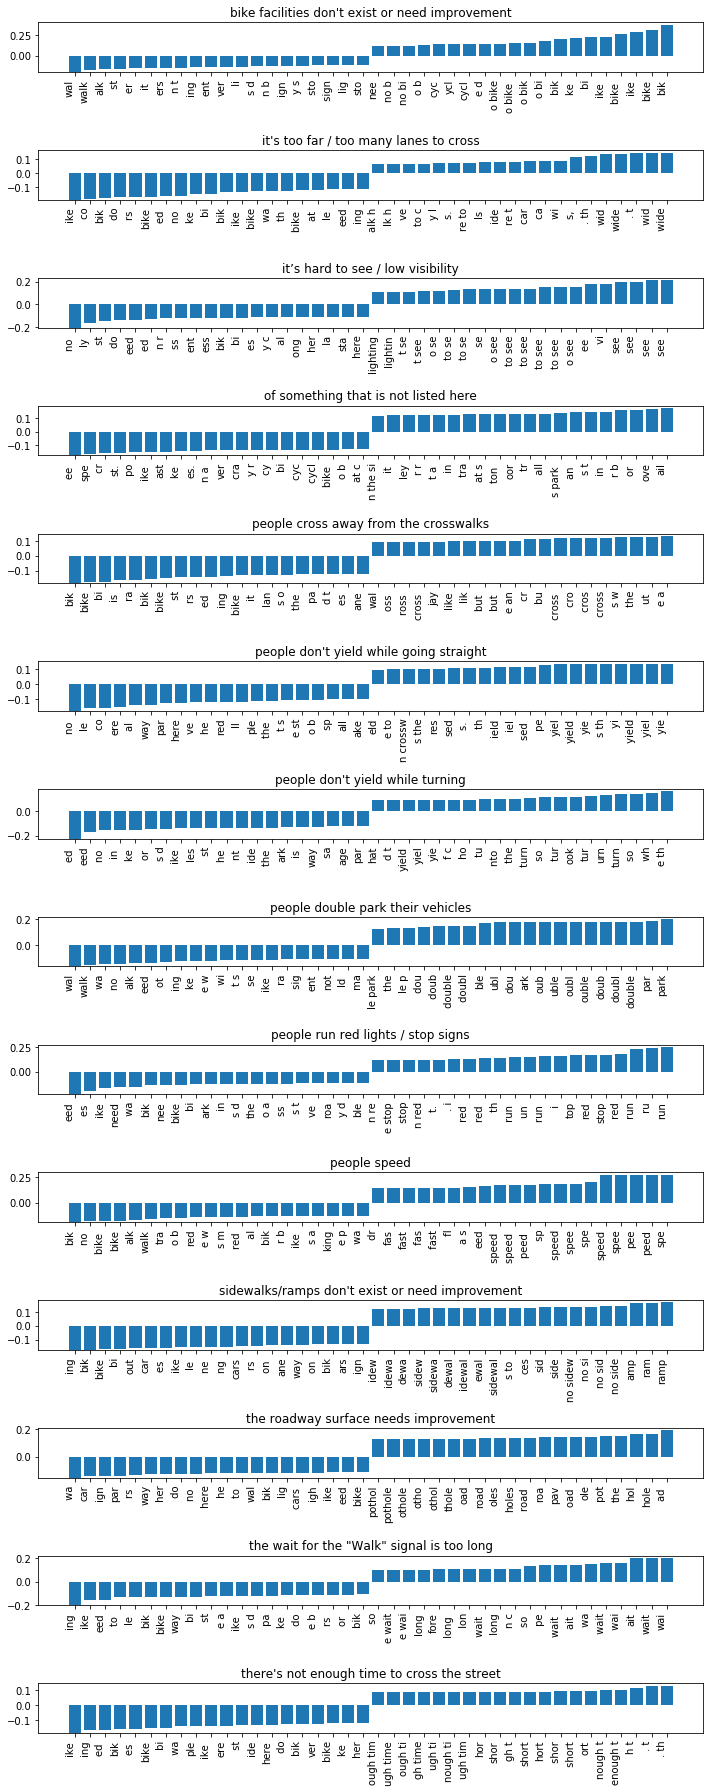

In [82]:
#Plot the most important character n-grams for each category


feature_names = lr_lemma_pipe.named_steps['countvectorizer'].get_feature_names()

def plot_important_features(coef, feature_names, top_n=20, ax=None):
    if ax is None:
        ax = plt.gca()
    
    inds = np.argsort(coef)
    low = inds[:top_n]
    high = inds[-top_n:]
    important = np.hstack([low, high])
    myrange = range(len(important))

    ax.bar(myrange, coef[important])
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[important], rotation=90, ha='right')

n_classes = len(lr_lemma_pipe.classes_)

fig, axes = plt.subplots(n_classes, figsize=(10, 25))

for ax, coef, label in zip(axes.ravel(),
                           lr_lemma_pipe.named_steps['logisticregression'].coef_,
                          lr_lemma_pipe.classes_):

    ax.set_title(label)
    plot_important_features(coef, np.array(feature_names), top_n=20, ax=ax)
    
plt.tight_layout()
    

In [ ]:
#Filter out the misclassified comments and show some examples


misclassified = np.stack((np.array(comments_train), np.array(target_train), preds), axis=-1)
misclassified = misclassified[misclassified[:, 1] != misclassified[:, 2]]


for complaint in range(0, 2000, 400):
    print('\n', misclassified[complaint, 0], '\n',
          '\n', 'true category:', misclassified[complaint, 1],
          '\n', 'misclassified as:', misclassified[complaint, 2])



 Poor markings. Poor visibility. No bike infra. Poor ped infra. Speeding. Too many games of chicken. I've had numerous close calls on bike and driving here. 
 
 true category: of something that is not listed here 
 misclassified as: bike facilities don't exist or need improvement

 This road needs to be repaved. Very dangerous as a biker since the road is so uneven and there are no bike lanes ANYWHERE! 
 
 true category: the roadway surface needs improvement 
 misclassified as: bike facilities don't exist or need improvement

 I've been almost hit many times here. Pedestrians are not very visible to cars turning left from Stoughton and right from Dudley. No turns on red please! Bulbs outs would be great, too! 
 
 true category: people don't yield while turning 
 misclassified as: of something that is not listed here

 Pedestrians cross the eastbound Commonwealth Ave lanes while cars are making U turns from westbound to eastbound Commonwealth Ave.  The light is short so cars rush throu

# Task5 - Clustering [10 points]

Apply LDA, NMF and K-Means to the whole dataset. Can you find clusters or topics that match well with some of the ground truth labels? Use ARI to compare the methods and visualize topics and clusters.

In [19]:

cv = CountVectorizer(min_df=2, ngram_range=(1, 4), analyzer='word', stop_words='english')
vec_comments = cv.fit_transform(comments)
feature_names = cv.get_feature_names()


In [21]:
#Perform a grid search to find the most sensible number of clusters for K-Means clustering 
#Calculate the ARI for each iteration (from 3 to 20 clusters)
#Print the first 5 comments in each cluster


km_ari = np.zeros((18,))

for n_cluster in range(18):
    km = KMeans(n_clusters=n_cluster+3, n_jobs=8, random_state=3)
    vec_comments = cv.fit_transform(comments)
    km.fit(vec_comments)
    km_preds = km.predict(vec_comments)
    
    km_ari[n_cluster] = adjusted_rand_score(target, km_preds)
    
    print(n_cluster+3, 'bin count', np.bincount(km_preds))
    km_clusters = np.stack((np.array(comments), km_preds), axis=-1)

    for cluster in range(n_cluster+3):
        try:
            print('number of clusters', n_cluster+3, 'cluster #', cluster, '\n', 
                  km_clusters[km_clusters[:, 1] == cluster][0:5, 0], '\n')
        except: continue


3 bin count [ 683 1448 4313]
number of clusters 3 cluster # 0 
 [ "This intersection is dangerous. Cars don't follow the lane markings (ie go straight while in turn lane) so it's nearly impossible to safely position yourself on a bike. In a car, people are trying to move over/it's unclear where people are going."
 'People turn from both the middle lane (not a turn lane) and from the actual turn lane. Just yesterday saw two cars in a row do it and almost witnessed a car accidents and walkers be hit.'
 'Cars FREQUENTLY turn right onto Bay State road from the left lane on Carlton'
 'The bike lane markings have worn away'
 'There are four lanes here. One is a left turn only. The other three try to merge into one. Making the rightmost lane right turn only & painting a bike lane would help.  Maybe a bike only signal to give cyclists a headstart to clear the intersection'] 

number of clusters 3 cluster # 1 
 [ "It's terrifying to walk over here. It seems like it's impossible to get the cars 

In [22]:
#Perform a grid search to find the most sensible number of topics for LDA
#Calculate the ARI for each iteration
#Print the top 20 feature words in each topic


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
cv = CountVectorizer(min_df=2, ngram_range=(1, 4), analyzer='word', stop_words='english')
vec_comments = cv.fit_transform(comments)
feature_names = cv.get_feature_names()

lda_ari = np.zeros((18,))

for topics in range(18):
    lda = LatentDirichletAllocation(n_topics=topics+3, learning_method='batch', n_jobs=8, random_state=3)
    lda.fit(vec_comments)
    lda_clusters = (np.argmax(lda.transform(vec_comments), axis=1))
    ari = adjusted_rand_score(target, lda_clusters)
    lda_ari[topics] = ari
    print('number of topics:', topics+3)
    print_top_words(lda, feature_names, 20)


number of topics: 3
Topic #0:
people cars light street red stop cross speed walk pedestrians intersection run right traffic way drivers lights st sign turn
Topic #1:
bike lane cars traffic left street turn st lanes bike lane people right way intersection parking dangerous road park double drivers
Topic #2:
pedestrians crosswalk street cross drivers walk stop traffic light crossing sign cars intersection dangerous st pedestrian people ave yield signal

number of topics: 4
Topic #0:
people cars light red stop cross walk street pedestrians speed intersection traffic run right lights way signal drivers sign red light
Topic #1:
lane cars bike left turn traffic st right street people intersection bike lane lanes dangerous turning way drivers parking road ave
Topic #2:
pedestrians crosswalk cross street stop walk drivers light sign traffic crossing cars dangerous yield intersection pedestrian people stop sign signal turning
Topic #3:
bike street park people lane way lanes cars road double sid

In [ ]:
#6, 7, 9, 10, 12, 15 topics

In [19]:
#Perform a grid search to find the most sensible number of components for NMF
#Calculate the ARI for each iteration
#Print the top 20 feature words in each topic


scaler = MaxAbsScaler()
nmf = NMF(n_components=10, tol=0.1, random_state=3)

scaled_vec = scaler.fit_transform(vec_comments)
nmf.fit(scaled_vec)
comments_nmf = nmf.transform(scaled_vec)
#print(comments_nmf)
print(nmf.components_)


[[ 0.00181828  0.00166606  0.0020655  ...,  0.01012515  0.01012515
   0.01012515]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.00341993  0.          0.00294194 ...,  0.          0.          0.        ]
 ..., 
 [ 0.0022631   0.00305741  0.00096014 ...,  0.          0.          0.        ]
 [ 0.00221009  0.00167539  0.00163952 ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]


In [24]:
#Show the ARI for each iteration of each clustering method


print('K-Means:', km_ari)
print('LDA:', lda_ari)


K-Means: [ 0.0034333   0.00979347  0.00974627  0.01300254  0.01287464  0.03415864
  0.03950653  0.04678254  0.03244342  0.03634926  0.03289181  0.03292393
  0.03475261  0.03311317  0.03712333  0.0282325   0.03036312  0.05522146]
LDA: [ 0.06296816  0.0505609   0.04787787  0.05119599  0.05334882  0.04661305
  0.0433204   0.04762683  0.0434452   0.03590861  0.03599169  0.04190784
  0.04228236  0.04514223  0.04298226  0.03907286  0.03355742  0.04296876]


# Task6 - Model 3 [30 points]

Improve the class definition for REQUESTTYPE by using the results of the clustering and results of the previous classification model. Re-assign labels using either the results of clustering or using keywords that you found during data exploration. The labels must be semantically meaningful.
The data has a large “other” category. Apply the topic modeling and clustering techniques to this subset of the data to find possible splits of this class.
Report accuracy using macro average f1 score (should be above .53) 


In [ ]:
# Add your code for task 6 here. You may use multiple cells. 



# Extra Credit [Up to +20 points]

Use a word embedding representation like word2vec for step 3 and or step 6. 

In [ ]:
# Add your code for extra credit here. You may use multiple cells. 

